In [34]:
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tq
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pickle
from keras.models import load_model
from keras.models import Sequential
from keras.models import Model
from keras.utils.layer_utils import layer_from_config
from keras.layers import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import load_img,img_to_array, array_to_img
import itertools
import gc
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import model_from_json
from keras.applications.inception_v3 import InceptionV3
from pipeline_functions import *
from keras.models import model_from_json
from utils import *
import heatmaps_to_rect as htr
import meta

### Given a list of pictures names, we should be able run the entire algorithm on them.

In [2]:
sub_fold = "./Submission/"
mk(sub_fold)
mk(sub_fold + "submission_csv")
mk(sub_fold + "test_data")
mk(sub_fold + "halfway_vectors")
mk(sub_fold + "heatmaps")
mk(sub_fold + "models")

This is what needs to be modified manually

In [14]:
# Precomputing
precompute_network_name = "resnet"
pictures_sizes = [(768, 1216),(1344,2240)]
file_model_precompute = "ResNet_cut.h5"

# Generate heatmaps
file_model_heatmaps = "fish_detection_trained_1.1.h5"
model_heatmaps_name = "simple_first_model"

# Find the boat
boat_classifier_file = ""
treashold = 0.9

# Find rectangles
threshold = 0
ranges=(11,71)
clip = 0.2
border_conf=[(11,3),(71,10)]
batch_size=1
max_fish=2

# Predict
model_predictions = "model55.json"
model_predictions_weights = "model_weights55.h5"

In [6]:
# the format of pictures_meta is (filename, height, width)
pictures_meta = meta.create_metadata_test(sub_fold)
fold_precompute = sub_fold+ "halfway_vectors/" + precompute_network_name + "/"
mk(fold_precompute)
fold_heatmaps = sub_fold + "heatmaps/" + model_heatmaps_name + "/"
mk(fold_heatmaps)
path_model_precompute = sub_fold + "models/" + file_model_precompute
path_model_heatmaps = sub_fold + "models/" + file_model_heatmaps
path_model_predictions = sub_fold + "models/" + model_predictions
path_weights_predictions = sub_fold + "models/" + model_predictions_weights

In [7]:
pictures_meta[0]

('./Submission/test_data/img_00005.jpg', 'img_00005.jpg', 720, 1280)

### We generate mid-network vectors:

In [8]:
generate_intermediary_vectors(pictures_meta, pictures_sizes, fold_precompute, path_model_precompute)

C:\Program Files\Anaconda3\lib\site-packages\keras\models.py:148: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/yolo/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpe982ki_f/m9a6bd0eb5ed5c92e91261282fc495cb4.lib and object C:/Users/yolo/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpe982ki_f/m9a6bd0eb5ed5c92e91261282fc495cb4.exp



### We compute the heatmaps:

In [9]:
heatmaps = create_heatmaps(pictures_meta, fold_precompute, pictures_sizes, path_model_heatmaps, fold_heatmaps)

In [8]:
heatmaps.shape

(1000, 5, 36, 64)

1.19246077538


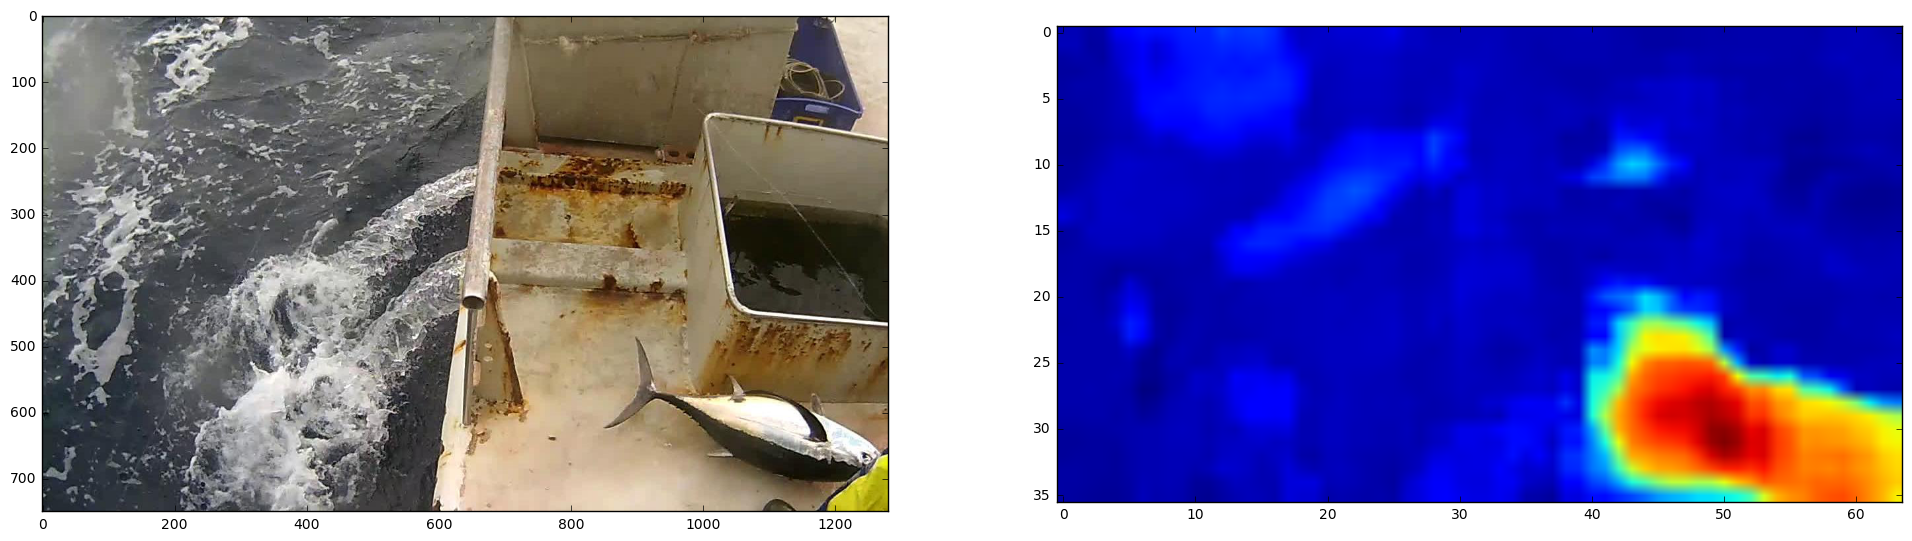

0.609962165356


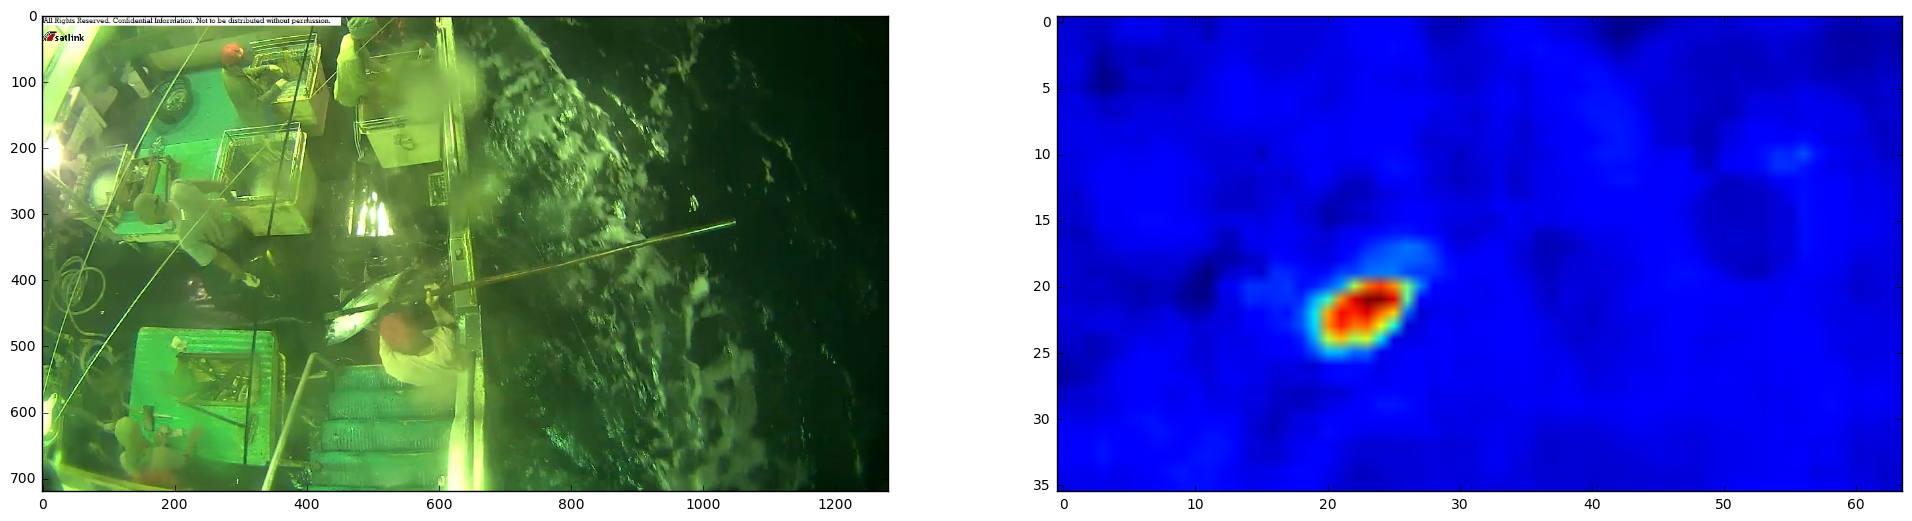

In [10]:
show_heatmaps(heatmaps, pictures_meta, 200, mask_idx=0, nb_to_show = 2)

### We find the boats:

### We find the rectangles:

In [15]:
rectangles, scores = htr.find_rectangles(heatmaps, threshold, ranges, clip, border_conf=border_conf,
                                     batch_size=batch_size, max_fish=max_fish, scores=True)

In [16]:
new_rectangles = resize_rectangles(rectangles, pictures_meta, heatmaps.shape[-1], heatmaps.shape[-2])

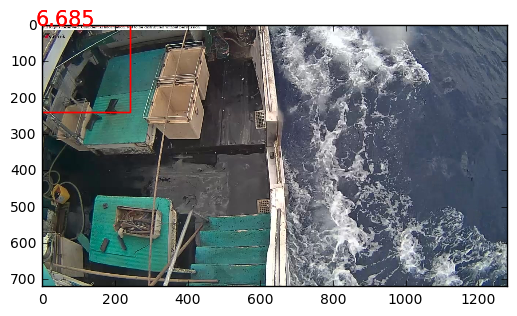

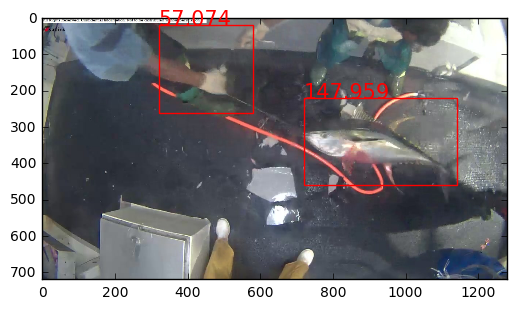

In [17]:
print_rectangles(new_rectangles, scores,pictures_meta, 0, nb_to_show = 2)

### We crop the images:

In [43]:
def crop_images(pictures_meta, new_rectangles):
    cropped = []
    
    for rects, (path, f_name, height, width) in tq(zip(new_rectangles,pictures_meta)):
        img_crops = []
        img = Image.open(path)
        for rect in rects:
            crop = img.crop((rect[1],rect[0] ,rect[1] + rect[3], rect[0]+ rect[2]))
            crop = img_to_array(crop)
            crop = np.expand_dims(crop, axis=0)
            img_crops.append(crop)
        cropped.append(img_crops)
    return cropped

In [44]:
cropped = crop_images(pictures_meta, new_rectangles)

In [45]:
type(cropped[0])

list

In [46]:
for i,x in enumerate(cropped):
    cropped[i].append(np.zeros((1,3,200,200)))
    cropped[i].append(np.zeros((1,3,200,200)))

In [47]:
cropped[0][0].shape

(1, 3, 240, 260)

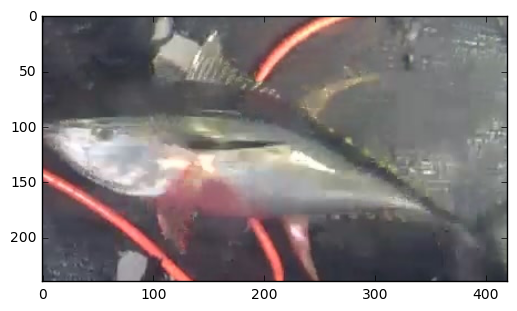

In [51]:
plt.imshow(array_to_img(cropped[1][0][0]))
plt.show()

### We apply the classifier:

In [56]:
def species_classifier(cropped, path_model_predictions, path_weights):
    with open(path_model_predictions, 'r') as myfile:
        json_string = myfile.read()
    model = model_from_json(json_string)
    model.load_weights(path_weights)
    
    #model = load_model(path_model_predictions)
    p_species = []
    
    for img in tq(cropped):
        p_species_img = []
        p_species_img = model.predict(img)[0]
        p_species.append(p_species_img)
        
    return p_species
    

In [57]:
p_species = species_classifier(cropped, path_model_predictions, path_weights_predictions)

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/yolo/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpcwp74jd0/mc137423ffe0dd36d1849443c7f5d96a2.lib and object C:/Users/yolo/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpcwp74jd0/mc137423ffe0dd36d1849443c7f5d96a2.exp



In [65]:
for i in range(len(p_species)):
    if p_species[i][0]> 0.9:
        p_species[i][0] = 0.9
        print("yolo")
        p_species[i][1:] = p_species[i][1:]*0.1 / np.sum(p_species[i][1:])

yolo
yolo
yolo
yolo
yolo
yolo
yolo
yolo
yolo
yolo
yolo
yolo
yolo
yolo
yolo
yolo
yolo
yolo
yolo
yolo
yolo
yolo
yolo
yolo
yolo
yolo
yolo


In [66]:
np.sum(p_species)

1000.0

In [64]:
p_species[2]

array([  2.52041559e-07,   1.92418918e-02,   9.79851902e-01,
         5.07511897e-04,   2.11350630e-06,   5.37587141e-07,
         9.23320840e-07,   3.94943345e-04], dtype=float32)

In [ ]:
p_species = np.a

### Creating the csv:

In [67]:
def create_submission(predictions, info):
    import pandas as pd
    import datetime
    
    
    # WE NEED TO CHANGE THIS PART BECAUSE THE CODES FOR THE CLASSES HAS CHANGED 
    
    
    
    #result1 = pd.DataFrame(predictions, columns=['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT','image'])
    result1 = pd.DataFrame(predictions, columns=['image','NoF', 'OTHER', 'ALB', 'BET','DOL', 'LAG', 'SHARK', 'YFT'])
    #result1.loc['image',:] = pd.Series(test_id, index=result1.index)
    now = datetime.datetime.now()
    sub_file = 'submission_' + info + '_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
    result1.to_csv(sub_file, index=False)
    print('done',sub_file)


def to_csv(final_predictions, pictures_meta):
    imgs_name = [x[1] for x in pictures_meta]
    output = []
    for prediction,img_name in zip(np.array(final_predictions).tolist(),imgs_name):
        output.append(np.hstack((np.array(img_name),prediction)))
    create_submission(output,'') 

In [68]:
to_csv(p_species, pictures_meta) #Must print the submission number

done submission__2017-01-23-22-30.csv
